## Input Image Processing

IN this notebook I look at methods of processing input image, in order to remove image noise (background) as well as centering and resizing the image in order for it to be in the same format as the images in the database. Once this is complete the image can be processed useing the methods found in ***Image_Histogram_Builder.ipynb*** and ***Image_Features.ipynb***.

In [2]:
% matplotlib inline
import skimage
import cv2
import numpy as np
import matplotlib.pyplot as plt
import argparse

OpenCV has a number of different threshholding tools, this allows differntiating between colour shades and similar density groups. The plot below shows a sample input image and the results of various threashholding measures. Thresholding works by taking a input level at which to threshold and for a binary threshold setting all the values to 0 or 1 above and below this threshold, for other measure different formula are used.

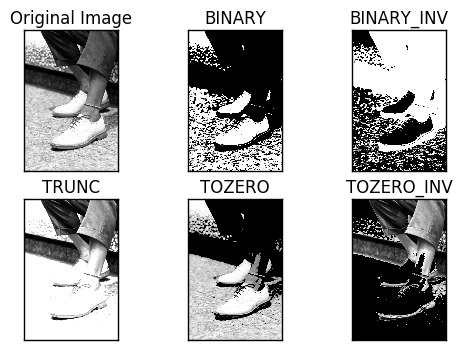

In [6]:
img = cv2.imread('test_image.jpg',0)
ret,thresh1 = cv2.threshold(img,200,255,cv2.THRESH_BINARY)
ret,thresh2 = cv2.threshold(img,200,240,cv2.THRESH_BINARY_INV)
ret,thresh3 = cv2.threshold(img,127,240,cv2.THRESH_TRUNC)
ret,thresh4 = cv2.threshold(img,127,240,cv2.THRESH_TOZERO)
ret,thresh5 = cv2.threshold(img,127,240,cv2.THRESH_TOZERO_INV)

titles = ['Original Image','BINARY','BINARY_INV','TRUNC','TOZERO','TOZERO_INV']
images = [img, thresh1, thresh2, thresh3, thresh4, thresh5]

for i in xrange(6):
    plt.subplot(2,3,i+1),plt.imshow(images[i],'gray')
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])

Below are a number of other thresholding options, along with a binary thrshold with the greyscal level at which to threshold altered. 

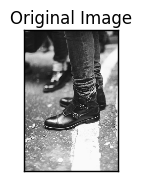

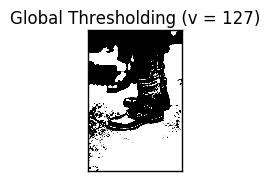

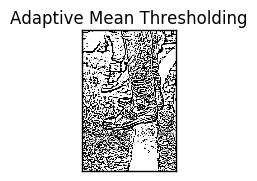

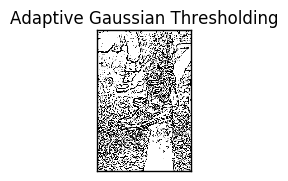

In [6]:
ret,th1 = cv2.threshold(img,127,255,cv2.THRESH_BINARY)

th2 = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,11,2)

th3 = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,2)

titles = ['Original Image', 
          'Global Thresholding (v = 127)',
          'Adaptive Mean Thresholding', 
          'Adaptive Gaussian Thresholding']
images = [img, th1, th2, th3]

for i in xrange(4):
    plt.subplot(2,2,i+1),plt.imshow(images[i],'gray')
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])
    plt.show()

OpenCV also has an edge detection method, that I thought could be used to form image contours that would be used to enclose areas of importance but discarding the rest. However on running the tool on a higher definition input image it picked up far too much detail and would not therefore be very helpful.

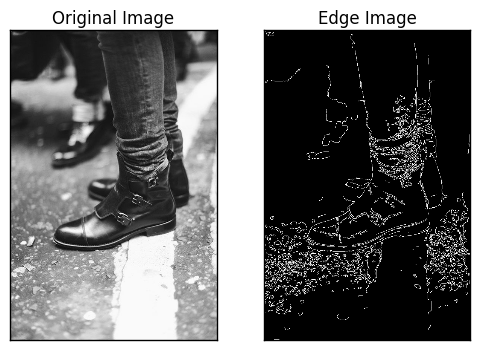

In [7]:
edges = cv2.Canny(img,100,200)
plt.subplot(121),plt.imshow(img,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(edges,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
 
plt.show()

## Photo Masking/Cropping

Using the thresholding methods above and some other Opencv functions I will attempt to mask an image, I will use a user input in the form of a mouse click on the shoe to tell the function where the shoe is so it can cut the noise from around this region out.

In [14]:
## Input image.
Image_URL='Test_Images_Input/Test_Image_2.jpg'

In [15]:
## Read input image
img = cv2.imread(Image_URL)

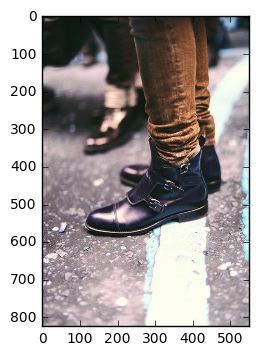

In [16]:
## Display the image
plt.imshow(img)

In [17]:
## This function regesters and returns a mouse click location
refPt = []
Click = False
 
def click_location(event, x, y, flags, param):
    # grab references to the global variables
    global refPt, Click
 
    # if the left mouse button was clicked, record the starting
    # (x, y) coordinates and indicate that cropping is being
    # performed
    if event == cv2.EVENT_LBUTTONDOWN:
        refPt = [(x, y)]
        Click = True

In [18]:
## The input image is opened and the program loops until a click is made, once this has occured the image is closed
## and the location of the click on the image is recorded.
cv2.namedWindow("image")
cv2.setMouseCallback("image", click_location)
# keep looping until the right mouse button is pressed
while Click==False:
    # display the image and wait for a keypress
    cv2.imshow("image", img)
    key = cv2.waitKey(1) & 0xFF
    if key == ord("c"):
        break
# close all open windows
cv2.destroyAllWindows()

I will be using binary thresholding as it seems to work the best for masking objects, however the first step is to determine if the shoe in question is towards the dark or light end of the colour spectrum, as if it is a white shoe I will need to use the inverted binary thresholding, as from this point onwards light colours are seen as background.

In [19]:
## Find the RGB values at the location of the mouse click.
Ref_Point=[refPt[0][1],refPt[0][0]]
R,G,B=img[Ref_Point[0],Ref_Point[1]]

## If the shoe is lighted colour turn the 'White' binary varible to True
White=False
if R>=200 and G>=200 and B>=200:
    White=True
        
## Reopens the image as a greyscale image which is required for binary thresholding
grey = cv2.imread(Image_URL,0)

## If the shoe is white use inverted binary thresholding, if not use normal
if White==True:
    ret,thresh = cv2.threshold(grey,200,255,cv2.THRESH_BINARY)    
else:
    ret, thresh = cv2.threshold(grey,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)


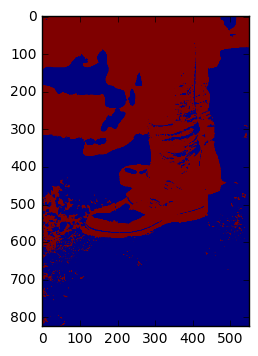

In [20]:
## Plot an image of the thresholded image
plt.imshow(thresh)

Below I am using a series of tools to try and located sure forground colours and sure background. Each step is plotted below.

In [21]:
# noise removal
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2) 
# sure background area
sure_bg = cv2.dilate(opening,kernel,iterations=3) 
# Finding sure foreground area
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
ret, sure_fg = cv2.threshold(dist_transform,0.05*dist_transform.max(),255,0) 
# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)

(<matplotlib.axes._subplots.AxesSubplot at 0x114995ad0>,
 <matplotlib.image.AxesImage at 0x119011d10>)

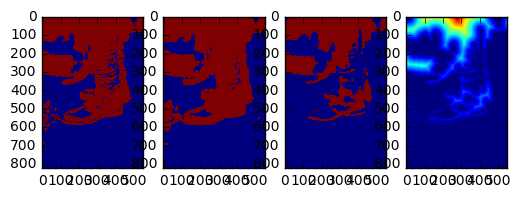

In [22]:
plt.subplot(141),plt.imshow(opening)
plt.subplot(142),plt.imshow(sure_bg)
plt.subplot(143),plt.imshow(sure_fg)
plt.subplot(144),plt.imshow(dist_transform)

In [23]:
# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)
# Add one to all labels so that sure background is not 0, but 1
markers = markers+1
# Now, mark the region of unknown with zero
markers[unknown==255] = 0

The image has now been broken down into different layers, these are lableled as markers and disaplayed below. I will use the user input click to locate the marker group that is defintely the shoe.

In [24]:
markers = cv2.watershed(img,markers)
img[markers == -1] = [255,0,0]

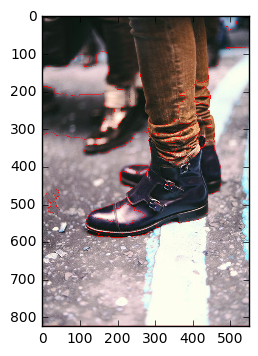

In [25]:
plt.imshow(img)

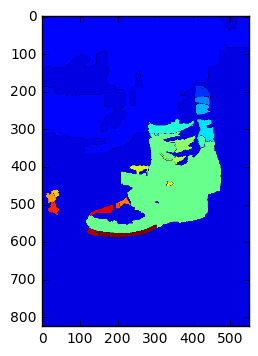

In [26]:
plt.imshow(markers)

The user input should have clicked on the green zone so the image will now be masked around this area, as this is the definite shoe area.

In [27]:
## Selecting only the area relating to where the user clicked.
mask=[markers!=markers[Ref_Point[0],Ref_Point[1]]]

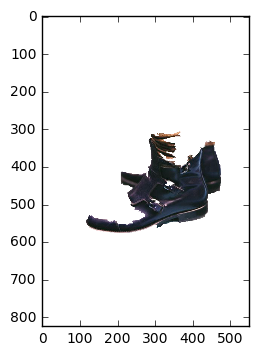

In [28]:
## Plotting the base image with the mask applied
img2=img.copy()
img2[mask]=[255, 255, 255]
plt.imshow(img2)

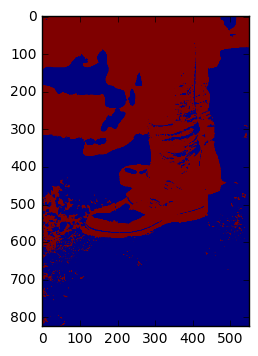

In [29]:
plt.imshow(thresh)

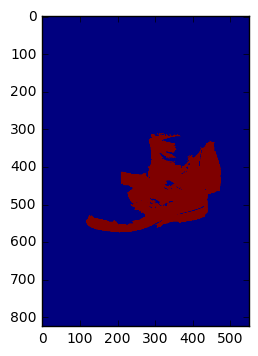

In [30]:
## Masking the thresholded image
thresh[mask]=0
plt.imshow(thresh)

We now have a difinitive area of shoe, I will now use this to generate a rectangle around this area (Slightly enlarged to grab any missing bits). And repeat the process using OpenCVs inbult masking method, the reason I had to do my own is that Open CVs method requires an input area of definte forground, and so I needed to include a background area. There I will use the hole image, with a rectangle overplayed that contains all of the definte foreground. OpenCV is then able to see what sections of the image overlap foreground and background and assign these to background.

In [31]:
## Finding the size of the image.
rows=np.sum(thresh,axis=1)
columns=np.sum(thresh,axis=0)

In [32]:
## Creating a rectangle values that encapsulates the mask.
x,y,w,h=int(np.min(np.nonzero(columns))),int(np.min(np.nonzero(rows))),int(len(np.nonzero(columns)[0])),int(len(np.nonzero(rows)[0]))

In [33]:
## Increaseing the size of the rectangle by a few pixels incase the entire shoe has not been captured.
if x>20:
    x_new=x-20
if y>20:
    y_new=y-20
w_new=w+40
h_new=h+40

In [34]:
## Creating a rectangle on the image (for viewing purposes)
rectangle_img=cv2.rectangle(img,(x_new,y_new),(x_new+w_new,y_new+h_new),(0,0,255),2)

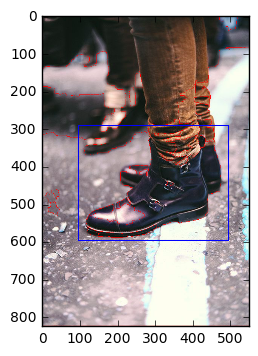

In [35]:
## Plotting the image with the rectangle on top.
plt.imshow(rectangle_img)

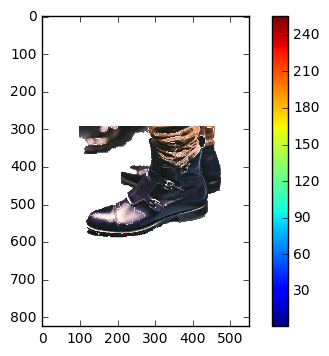

(<matplotlib.image.AxesImage at 0x11d5f8710>,
 None)

In [36]:
## Creates a mask the size of the image
mask = np.zeros(img.shape[:2],np.uint8)

## Creates arbitary arrays of zero for the background and foreground
bgdModel = np.zeros((1,65),np.float64)
fgdModel = np.zeros((1,65),np.float64)

## Creates a rectangle the size of that described above
rect = (x_new,y_new,w_new,h_new)

## Uses OpenCVs grab cut function to remove background
cv2.grabCut(img,mask,rect,bgdModel,fgdModel,5,cv2.GC_INIT_WITH_RECT)

## Removes all background info.
mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
img = img*mask2[:,:,np.newaxis]
img[img==0]=255
plt.imshow(img),plt.colorbar(),plt.show()

In [37]:
## Crops the image and resizes it to 200x200 for input into the histogram generator.
if w_new>h_new:
    h_dff=(w_new-h_new)
    y_new=y_new-(h_dff/2)
    if y_new<0:
        y_new=0
    h_new=h_new+h_dff
elif h_new>w_new:
    w_dff=(h_new-w_new)
    x_new=x_new-(w_dff/2)
    if x_new<0:
        x_new=0
    w_new=w_new+w_dff
crop_img = img[y_new:y_new+h_new,x_new:x_new+w_new]
out_img=cv2.resize(crop_img, (200, 200)) 

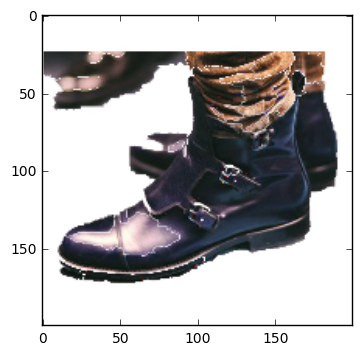

In [38]:
plt.imshow(out_img)

In [709]:
## Saves the image
cv2.imwrite('Test_Images/Street_No_Bk/Test_2.jpg',out_img)

True